<a href="https://colab.research.google.com/github/Fcazarez/RRC3_NNandDL_ass6_emotion_classification/blob/main/Copia_de_la_copia_de_Assignment_6_Emotion_Classification_FFE_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COMP-3704 (241552) Neural Networks and Deep Learning
### Assignment 6 - Emotion Classification
### Group 3 - Francisco, Felix, Elizer

### Objective:
To create a model that can identify the emotion (joy, sadness, anger or fear) of a tweet.

### Data:
The dataset is available at Emotion Classification NLP | Kaggle . Acknowledgment: WASSA-2017 Shared Task on Emotion Intensity. Saif M. Mohammad and Felipe Bravo-Marquez. In Proceedings of the EMNLP 2017 Workshop on Computational Approaches to Subjectivity, Sentiment, and Social Media (WASSA), September 2017, Copenhagen, Denmark.

### Problem Statement:
Identifying the emotion behind human text is an important part of NLP for various applications including customer review analysis and artificial intelligence. The owner of Twitter, Elon Musk has fired everyone who understood emotion classification of tweets because they were not "hard core" enough, and now their existing model is no longer working. As a new employee, your job is to develop a model that can classify the emotional connotation behind tweets. Mr. Musk does not disclose why this is needed but laughs eerily whenever asked about it.


In [ ]:
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=8e95a7680251a63b623895d29e6e6af466b226e61f210fba0579436c845a5d49
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from autocorrect import Speller

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SpatialDropout1D, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam

from timeit import default_timer as timer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#test_on_batch:
    #Scalar test loss (if the model has a single output and no metrics) or list of scalars
    #(if the model has multiple outputs and/or metrics).
    #The attribute model.metrics_names will give you the display labels for the scalar outputs.
    ##(result of loss funtion,accuracy)

def show_confusion_matrix(title, labels, y, y_predicted):
    cm = confusion_matrix(y, y_predicted)

    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

    fig, ax = plt.subplots(figsize=(3,3))
    plt.grid(False)
    plt.title(title)

    cmd.plot(ax=ax, colorbar=False, cmap=plt.cm.Blues, xticks_rotation="vertical")

def show_results(title, labels_map, labels, predicted, train_accu):

    show_confusion_matrix(title, labelsMap,labels, predicted)

    report = classification_report(labels, predicted, output_dict=True)
    accu = report["accuracy"]

    data = {'train': [train_accu],
        'validate': [accu]
        }

    df = pd.DataFrame(data, index=['accuracy'])
    display(df)

# base on : https://stackoverflow.com/questions/57181551/can-i-write-a-keras-callback-that-records-and-returns-the-total-training-time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

### 1. Data
### a.) Load the three datafiles into training, validation, and testing dataframes.

In [ ]:
#  Loading the three datafiles into training, validation, and testing dataframes.
df_train = pd.read_csv('https://raw.githubusercontent.com/ElizerLising/Group-3/main/emotion-labels-train.csv')
df_val = pd.read_csv('https://raw.githubusercontent.com/ElizerLising/Group-3/main/emotion-labels-val.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/ElizerLising/Group-3/main/emotion-labels-test.csv')

In [ ]:
df_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [ ]:
df_val.head()

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy


In [ ]:
df_test.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((3613, 2), (347, 2), (3142, 2))

In [ ]:
print("Train:", "\n", df_train.label.value_counts())
print("=="*30)
print("Validation:", "\n", df_val.label.value_counts())
print("=="*30)
print("Test:", "\n", df_test.label.value_counts())

Train: 
 fear       1147
anger       857
joy         823
sadness     786
Name: label, dtype: int64
Validation: 
 fear       110
anger       84
joy         79
sadness     74
Name: label, dtype: int64
Test: 
 fear       995
anger      760
joy        714
sadness    673
Name: label, dtype: int64


### b)
* Use pandas.DataFrame.info to check if the entries are the correct datatype, and if there are any missing values.
* Use pandas.DataFrame.duplicates to check for duplicate entries.
* Fix the dataset so that there are no missing values, duplicate rows, or incorrect data types.
* Use markdown to make observations and explain what you have done.

In [ ]:
print("Train:", "\n",df_train.info())
print("=="*30)
print("Validation:", "\n",df_val.info())
print("=="*30)
print("Test:", "\n",df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3613 non-null   object
 1   label   3613 non-null   object
dtypes: object(2)
memory usage: 56.6+ KB
Train: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    347 non-null    object
 1   label   347 non-null    object
dtypes: object(2)
memory usage: 5.5+ KB
Validation: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3142 non-null   object
 1   label   3142 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB
Test: 
 None


In [ ]:
# Calculate and print missing values for df_train
print("Total missing values in df_train:", df_train.isnull().sum().sum())

# Calculate and print missing values for df_val
print("Total missing values in df_val:", df_val.isnull().sum().sum())

# Calculate and print missing values for df_test
print("Total missing values in df_test:", df_test.isnull().sum().sum())

Total missing values in df_train: 0
Total missing values in df_val: 0
Total missing values in df_test: 0


In [ ]:
# Check and print the number of duplicates in df_train
duplicates_train = df_train.duplicated().sum()
print("Number of duplicates in df_train:", duplicates_train)

# Check and print the number of duplicates in df_val
duplicates_val = df_val.duplicated().sum()
print("Number of duplicates in df_val:", duplicates_val)

# Check and print the number of duplicates in df_test
duplicates_test = df_test.duplicated().sum()
print("Number of duplicates in df_test:", duplicates_test)

Number of duplicates in df_train: 0
Number of duplicates in df_val: 0
Number of duplicates in df_test: 0


In [ ]:
# Print the total sum of NaN values
print("Total sum of NaN values in df_train:", df_train.isna().sum().sum())

# Print the total sum of NaN values
print("Total sum of NaN values in df_val:", df_val.isna().sum().sum())

# Print the total sum of NaN values
print("Total sum of NaN values in df_test:", df_test.isna().sum().sum())

Total sum of NaN values in df_train: 0
Total sum of NaN values in df_val: 0
Total sum of NaN values in df_test: 0


## **Comments:**

**Dataset Overview:**

The dataset consists of text samples labeled with different emotions: fear, anger, joy, and sadness.
The training set has 3613 entries, the validation set has 347 entries, and the test set has 3142 entries.
Each entry has two columns: 'text' containing the text of the sample and 'label' containing the corresponding emotion label.
Class Distribution:

The distribution of emotions in the training set is as follows: fear (1147), anger (857), joy (823), sadness (786).
The validation set has a similar distribution, but with fewer samples for each emotion.
The test set also follows a similar pattern but with a larger number of samples.

**Data Types and Memory Usage:**

Both the training and validation sets have non-null entries with no missing values in the 'text' and 'label' columns.
The data types for both columns are 'object' (likely strings), and the memory usage is reasonable for the size of the datasets.

**Duplicates:**

There are no duplicate entries in the training, validation, or test sets, which is a positive aspect for data quality.

**Missing Values:**

There are no missing values (NaN) in any of the datasets, indicating that the data is complete and ready for analysis.

**Insights:**

The class distribution across the emotions appears to be reasonably balanced, which is beneficial for training models without a strong bias towards any specific emotion.
The absence of missing values and duplicates simplifies preprocessing and ensures the integrity of the dataset.
The memory usage is relatively low, suggesting that the dataset can be handled efficiently.

In general the dataset is clean and ready to go with modelling stage.

### C.)
* Move the labels into a separate dataframe and use sklearn.preprocessing.LabelEncoder to convert the string labels into integers.
* Reshape the labels into a 2d array. Determine which number has been assigned to each label and record this information in markdown.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming df_train, df_val, df_test are your datasets
datasets = [df_train, df_val, df_test]

label_encoder = LabelEncoder()

# Create separate DataFrames for labels
labels_dfs = [pd.DataFrame({'labels': label_encoder.fit_transform(df['label'])}) for df in datasets]

# Reshape the labels into 2D arrays for each dataset
labels_arrays = [labels_df['labels'].values.reshape(-1, 1) for labels_df in labels_dfs]

# Assign labels back to the original DataFrames
for i, df in enumerate(datasets):
    df['labels'] = labels_arrays[i]

# Access the labels for each dataset like this:
labels_train = labels_arrays[0]
labels_val = labels_arrays[1]
labels_test = labels_arrays[2]



# Record label information in Markdown
label_info = pd.DataFrame({'Label': label_encoder.classes_, 'Encoded Number': label_encoder.transform(label_encoder.classes_)})

#hand coded but base in the next dataframe
labelsMap = {}
labelsMap["anger"] = 0
labelsMap["fear"] = 1
labelsMap["joy"] = 2
labelsMap["sadness"] = 3


In [ ]:
label_info

,Label,Encoded Number
0,anger,0
1,fear,1
2,joy,2
3,sadness,3


In [ ]:
print(labels_train)
print("=="*30)
print(labels_val)
print("=="*30)
print(labels_test)

[[2]
 [2]
 [2]
 ...
 [3]
 [3]
 [3]]
[[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]

### d.) Create a bar plot using seaborn.barplot of the number of elements in each category over the entire dataset. Use markdown to comment on how well balanced the dataset is.

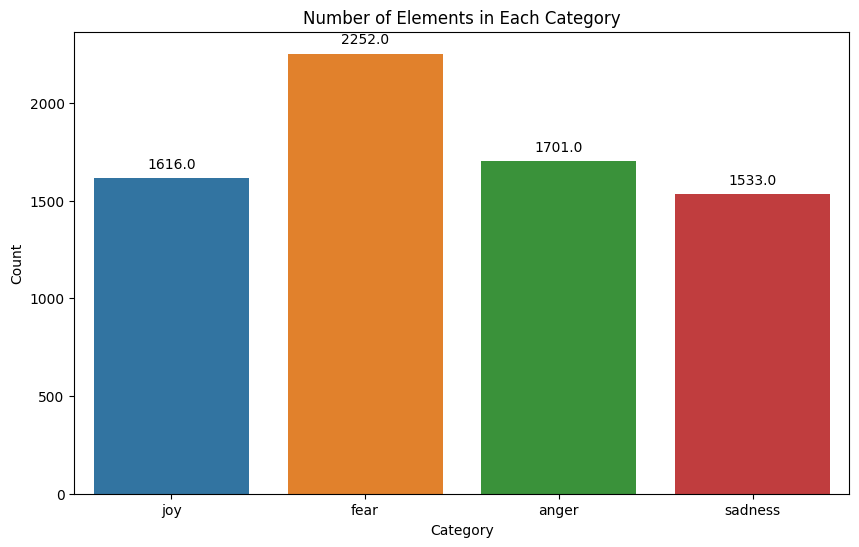

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_train, df_val, df_test are your datasets
datasets = [df_train, df_val, df_test]

# Combine all datasets into a single DataFrame
df_combined = pd.concat(datasets)

# Plot the bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=df_combined)

# Add count labels at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Number of Elements in Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


## **Comments:**

**Dataset Overview for Sentiment Analysis**

The dataset, though not perfectly balanced, is deemed suitable for sentiment analysis tasks. It exhibits variations in class distribution, with the highest count belonging to the "Fear" category, comprising 2252 elements. On the other hand, "Joy" features 1616 instances, while "Anger" and "Sadness" are closely balanced with 1701 and 1533 occurrences, respectively.

| Class     | Distribution |
|-----------|--------------|
| Fear      | 2252 elements|
| Joy       | 1616 elements|
| Anger     | 1701 elements|
| Sadness   | 1533 elements|

**Observations:**
1. **Imbalance:** The dataset shows an imbalance, particularly noticeable in the abundance of Fear instances. However, the distribution remains conducive for sentiment analysis, enabling the model to learn from both prevalent and less common sentiments.

2. **Balanced Classes:** Notably, the "Joy," "Anger," and "Sadness" classes exhibit a relatively balanced distribution, enhancing the model's ability to generalize across different emotional states.



### e.) Perform the following steps on the tweets in an order of your choosing:
* Tokenize each tweet into words.
* If you think it is useful, use Speller from the autocorrect library to correct spelling mistakes.
* Create a list of stopwords (using publicly available lists and/or adding your own) and remove these.
* Use PorterStemmer or WordNetLemmatizer from nltk.stem on the text.
* Use regular expressions (the re library) to do any additional cleanup of the text you wish to do.

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import re

# Init stopwords, lemmatizer, and speller
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')

# Define text processing functions
def lower_and_tokenize(text):
    text = text.lower()
    return word_tokenize(text)

def correct_spelling(tokenized_text):
    return [spell(word) for word in tokenized_text]

def remove_stopwords(tokenized_text):
    return [word for word in tokenized_text if word not in stop_words]

def lemmatize_text(tokenized_text):
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

def apply_regex(text):
    return re.sub(r'[^a-z\s]', '', text)

# Define a function to apply the entire processing pipeline
def process_text(df):

    df['tokenized_text'] = df['text'].apply(lower_and_tokenize)
    df['corrected_text'] = df['tokenized_text'].apply(correct_spelling)
    df['text_without_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
    df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['text'].apply(apply_regex)

# Apply the processing pipeline to your dataframes
process_text(df_test)
process_text(df_train)
process_text(df_val)

# Print specific columns for inspection
print(df_test[['text', 'tokenized_text', 'corrected_text', 'text_without_stopwords', 'lemmatized_text', 'cleaned_text']].head())
print(df_train[['text', 'tokenized_text', 'corrected_text', 'text_without_stopwords', 'lemmatized_text', 'cleaned_text']].head())
print(df_val[['text', 'tokenized_text', 'corrected_text', 'text_without_stopwords', 'lemmatized_text', 'cleaned_text']].head())


                                                text  \
0  You must be knowing #blithe means (adj.)  Happ...   
1  Old saying 'A #smile shared is one gained for ...   
2  Bridget Jones' Baby was bloody hilarious 😅 #Br...   
3  @Elaminova sparkling water makes your life spa...   
4  I'm tired of everybody telling me to chill out...   

                                      tokenized_text  \
0  [you, must, be, knowing, #, blithe, means, (, ...   
1  [old, saying, ', a, #, smile, shared, is, one,...   
2  [bridget, jones, ', baby, was, bloody, hilario...   
3  [@, elaminova, sparkling, water, makes, your, ...   
4  [i, 'm, tired, of, everybody, telling, me, to,...   

                                      corrected_text  \
0  [you, must, be, knowing, #, elite, means, (, a...   
1  [old, saying, ', a, #, smile, shared, is, one,...   
2  [bridge, jones, ', baby, was, bloody, hilariou...   
3  [@, elaminova, sparkling, water, makes, your, ...   
4  [i, 'm, tired, of, everybody, telling, me, 

### f.) Print out the words in the first five processed tweets along with their labels. (Viewing this may give you additional ideas for the previous steps.)

In [ ]:
labels_test_head = df_test['label'].head()
labels_train_head = df_train['label'].head()
labels_val_head = df_val['label'].head()

# Display the words and labels for the first five processed tweets
print("Processed Tweets in df_test:")
for index, row in df_test[['text', 'tokenized_text', 'corrected_text', 'text_without_stopwords', 'lemmatized_text', 'cleaned_text', 'label']].head().iterrows():
    print(f"\nLabel: {row['label']}")
    print(f"Original Text: {row['text']}")
    print(f"Tokenized Text: {row['tokenized_text']}")
    print(f"Corrected Text: {row['corrected_text']}")
    print(f"Text Without Stopwords: {row['text_without_stopwords']}")
    print(f"Lemmatized Text: {row['lemmatized_text']}")
    print(f"Cleaned Text: {row['cleaned_text']}")

print("\nProcessed Tweets in df_train:")
for index, row in df_train[['text', 'tokenized_text', 'corrected_text', 'text_without_stopwords', 'lemmatized_text', 'cleaned_text', 'label']].head().iterrows():
    print(f"\nLabel: {row['label']}")
    print(f"Original Text: {row['text']}")
    print(f"Tokenized Text: {row['tokenized_text']}")
    print(f"Corrected Text: {row['corrected_text']}")
    print(f"Text Without Stopwords: {row['text_without_stopwords']}")
    print(f"Lemmatized Text: {row['lemmatized_text']}")
    print(f"Cleaned Text: {row['cleaned_text']}")

print("\nProcessed Tweets in df_val:")
for index, row in df_val[['text', 'tokenized_text', 'corrected_text', 'text_without_stopwords', 'lemmatized_text', 'cleaned_text', 'label']].head().iterrows():
    print(f"\nLabel: {row['label']}")
    print(f"Original Text: {row['text']}")
    print(f"Tokenized Text: {row['tokenized_text']}")
    print(f"Corrected Text: {row['corrected_text']}")
    print(f"Text Without Stopwords: {row['text_without_stopwords']}")
    print(f"Lemmatized Text: {row['lemmatized_text']}")
    print(f"Cleaned Text: {row['cleaned_text']}")


Processed Tweets in df_test:

Label: joy
Original Text: You must be knowing #blithe means (adj.)  Happy, cheerful.
Tokenized Text: ['you', 'must', 'be', 'knowing', '#', 'blithe', 'means', '(', 'adj', '.', ')', 'happy', ',', 'cheerful', '.']
Corrected Text: ['you', 'must', 'be', 'knowing', '#', 'elite', 'means', '(', 'adj', '.', ')', 'happy', ',', 'cheerful', '.']
Text Without Stopwords: ['must', 'knowing', '#', 'blithe', 'means', '(', 'adj', '.', ')', 'happy', ',', 'cheerful', '.']
Lemmatized Text: ['you', 'must', 'be', 'knowing', '#', 'blithe', 'mean', '(', 'adj', '.', ')', 'happy', ',', 'cheerful', '.']
Cleaned Text: ou must be knowing blithe means adj  appy cheerful

Label: joy
Original Text: Old saying 'A #smile shared is one gained for another day' @YEGlifer @Scott_McKeen
Tokenized Text: ['old', 'saying', "'", 'a', '#', 'smile', 'shared', 'is', 'one', 'gained', 'for', 'another', 'day', "'", '@', 'yeglifer', '@', 'scott_mckeen']
Corrected Text: ['old', 'saying', "'", 'a', '#', 'smi

### g.) Create a histogram showing the lengths of the sequences after preprocessing. Comment on how this helps you to choose the maximum length hyperparameter used when truncating/padding the input sequences.

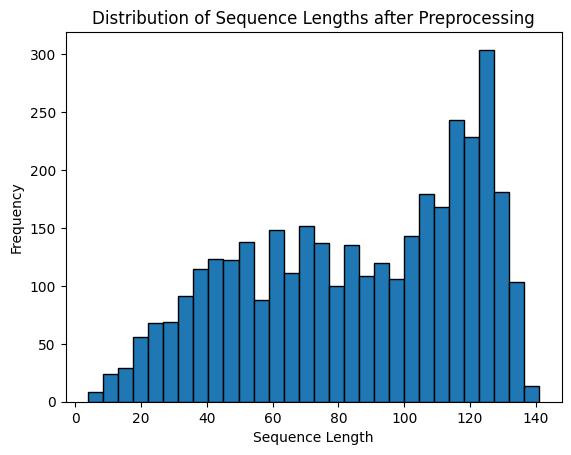

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a 'cleaned_text' column containing the preprocessed text
text_lengths = df_train['cleaned_text'].apply(len)

# Plotting the histogram
plt.hist(text_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Sequence Lengths after Preprocessing')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


## **Comments:**

The plot illustrates the distribution of sequence lengths after preprocessing the 'cleaned_text' column in the DataFrame df_train. The x-axis represents the sequence length, while the y-axis indicates the frequency or count of sequences falling within each length bin. The histogram shows the lengths are distributed across 30 bins.

Analyzing the plot provides insights into the typical length of sequences in the dataset. A peak in the histogram may indicate a prevalent sequence length, while any outliers or irregularities may be visually identified.

The histogram of sequence lengths provides helps in choosing the maximum length hyperparameter when truncating or padding input sequences. By observing the distribution, we can identify a length that captures the majority of sequences while minimizing information loss.

This information is crucial for understanding the characteristics of the text data after preprocessing.



## 2. Modeling

### a.) Create and compile a model using tf.keras.Sequential to predict the emotion label from the text. Start with an embedding layer and build an architecture from dense, LSTM, GRU, bidirectional LSTM or GRU, and dropout layers. Compile the model using a choice of optimizer, sparse_binary_crossentropy for the loss, and the metric set to accuracy.

In [ ]:
#df['cleaned_text']
#df_test
#df_train
#df_val
vocab_size = 200000
maxlen = 125

tok = Tokenizer(num_words=vocab_size)

tok.fit_on_texts(df_train['cleaned_text'])

train_sequences = tok.texts_to_sequences(df_train['cleaned_text'])
test_sequences = tok.texts_to_sequences(df_test['cleaned_text'])
val_sequences = tok.texts_to_sequences(df_val['cleaned_text'])
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)
X_val = pad_sequences(val_sequences, maxlen=maxlen)

In [ ]:
# taken directly from the book and modified for multiclass

model_lstm = Sequential()

model_lstm.add(Embedding(vocab_size, output_dim=64))
model_lstm.add(SpatialDropout1D(0.4))

model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dropout(0.4))

model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))

model_lstm.add(Dense(4, activation='sigmoid'))

model_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### b.) Train the model on the training data without using a validation split. Calculate and record the training accuracy.



In [ ]:
model_0_cb = TimingCallback()

history_lstm = model_lstm.fit(X_train, labels_train, batch_size=128, epochs = 10, callbacks=[model_0_cb])

Epoch 1/10
29/29 [==============================] - 53s 2s/step - loss: 1.3834 - accuracy: 0.2934
Epoch 2/10
29/29 [==============================] - 41s 1s/step - loss: 1.3743 - accuracy: 0.3188
Epoch 3/10
29/29 [==============================] - 41s 1s/step - loss: 1.2486 - accuracy: 0.4063
Epoch 4/10
29/29 [==============================] - 41s 1s/step - loss: 0.9845 - accuracy: 0.5356
Epoch 5/10
29/29 [==============================] - 40s 1s/step - loss: 0.7589 - accuracy: 0.6515
Epoch 6/10
29/29 [==============================] - 40s 1s/step - loss: 0.6928 - accuracy: 0.6980
Epoch 7/10
29/29 [==============================] - 40s 1s/step - loss: 0.5371 - accuracy: 0.7600
Epoch 8/10
29/29 [==============================] - 40s 1s/step - loss: 0.4407 - accuracy: 0.8281
Epoch 9/10
29/29 [==============================] - 40s 1s/step - loss: 0.3710 - accuracy: 0.8594
Epoch 10/10
29/29 [==============================] - 41s 1s/step - loss: 0.2644 - accuracy: 0.9131


### * c.) Use the model to make predictions on the validation data. Calculate and record the validation accuracy. Display the confusion matrix for the validation data. Use markdown to make comments.

### * d) Revisit the previous steps to make at least three models in total by changing architecture and hyperparameters.

### * e.) Present neatly the training and validation accuracy along with the validation confusion matrix for each model.

11/11 [==============================] - 4s 274ms/step


,train,validate
accuracy,0.913092,0.605187


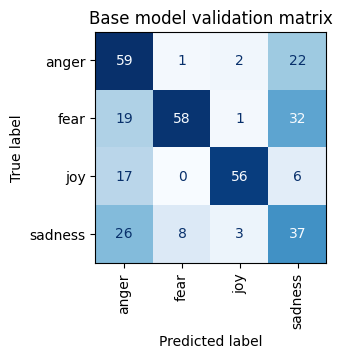

In [ ]:
lstm_accu = history_lstm.history['accuracy'][len(history_lstm.history['accuracy'])-1]
val_pred = model_lstm.predict(X_val)
val_pred = np.argmax(val_pred, axis=1)

show_results("Base model validation matrix", labelsMap,labels_val,val_pred, lstm_accu)

## **Comments:**
The model exhibits overfitting, seen in the disparity between high training accuracy (0.913) and lower testing accuracy (0.605). Address this by adjusting model complexity, exploring LSTM architecture improvements, and implementing regularization. Emphasize meticulous data preprocessing for sequence formatting and scaling.




In [ ]:
# model 2

model_1 = Sequential()

model_1.add(Embedding(vocab_size, output_dim=32))
model_1.add(SpatialDropout1D(0.4))


model_1.add(LSTM(64, return_sequences=True))
model_1.add(LSTM(64, return_sequences=False))
model_1.add(Dropout(0.5))

model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(4, activation='sigmoid'))

model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_1_cb = TimingCallback()
history_model_1 = model_1.fit(X_train, labels_train, batch_size=128, epochs = 10, callbacks=[model_1_cb])

Epoch 1/10
29/29 [==============================] - 21s 585ms/step - loss: 1.3810 - accuracy: 0.3047
Epoch 2/10
29/29 [==============================] - 17s 589ms/step - loss: 1.3765 - accuracy: 0.3158
Epoch 3/10
29/29 [==============================] - 17s 575ms/step - loss: 1.3754 - accuracy: 0.3175
Epoch 4/10
29/29 [==============================] - 14s 482ms/step - loss: 1.3729 - accuracy: 0.3169
Epoch 5/10
29/29 [==============================] - 15s 508ms/step - loss: 1.3607 - accuracy: 0.3296
Epoch 6/10
29/29 [==============================] - 17s 578ms/step - loss: 1.2833 - accuracy: 0.4005
Epoch 7/10
29/29 [==============================] - 17s 590ms/step - loss: 1.1371 - accuracy: 0.4758
Epoch 8/10
29/29 [==============================] - 17s 588ms/step - loss: 0.9935 - accuracy: 0.5372
Epoch 9/10
29/29 [==============================] - 17s 585ms/step - loss: 0.8810 - accuracy: 0.6023
Epoch 10/10
29/29 [==============================] - 15s 522ms/step - loss: 0.7787 - accura

11/11 [==============================] - 1s 45ms/step


,train,validate
accuracy,0.65375,0.443804


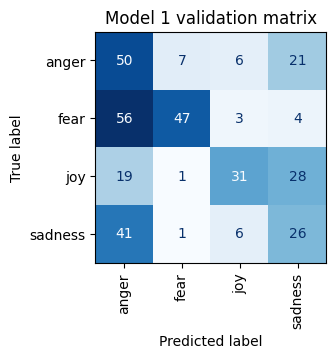

In [ ]:
lstm_accu_1 = history_model_1.history['accuracy'][len(history_model_1.history['accuracy'])-1]
val_pred_1 = model_1.predict(X_val)
val_pred_1 = np.argmax(val_pred_1, axis=1)

show_results("Model 1 validation matrix", labelsMap,labels_val,val_pred_1, lstm_accu_1)

**Comments:**

The model exhibits a discrepancy between training accuracy (0.65375) and validation accuracy (0.443804), indicating potential overfitting or challenges in generalization. Address this by adjusting model complexity, exploring regularization, and ensuring robust data preprocessing.

In [ ]:
model_2 = Sequential()

model_2.add(Embedding(vocab_size, output_dim=32))
model_2.add(SpatialDropout1D(0.4))

model_2.add(GRU(64, return_sequences=True))
model_2.add(GRU(64, return_sequences=False))
model_2.add(Dropout(0.4))

model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(4, activation='sigmoid'))

model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2_cb = TimingCallback()
history_model_2 = model_2.fit(X_train, labels_train, batch_size=128, epochs = 10, callbacks=[model_2_cb])

Epoch 1/10
29/29 [==============================] - 23s 531ms/step - loss: 1.3837 - accuracy: 0.2812
Epoch 2/10
29/29 [==============================] - 16s 547ms/step - loss: 1.3770 - accuracy: 0.3147
Epoch 3/10
29/29 [==============================] - 17s 573ms/step - loss: 1.3237 - accuracy: 0.3756
Epoch 4/10
29/29 [==============================] - 17s 603ms/step - loss: 1.1616 - accuracy: 0.4700
Epoch 5/10
29/29 [==============================] - 17s 600ms/step - loss: 0.9374 - accuracy: 0.5934
Epoch 6/10
29/29 [==============================] - 17s 598ms/step - loss: 0.7223 - accuracy: 0.6931
Epoch 7/10
29/29 [==============================] - 17s 607ms/step - loss: 0.5795 - accuracy: 0.7650
Epoch 8/10
29/29 [==============================] - 17s 584ms/step - loss: 0.4854 - accuracy: 0.8032
Epoch 9/10
29/29 [==============================] - 16s 526ms/step - loss: 0.3945 - accuracy: 0.8525
Epoch 10/10
29/29 [==============================] - 16s 534ms/step - loss: 0.3137 - accura

11/11 [==============================] - 2s 37ms/step


,train,validate
accuracy,0.892056,0.706052


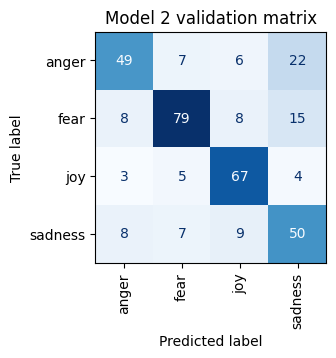

In [ ]:
val_pred_2 = model_2.predict(X_val)
val_pred_2 = np.argmax(val_pred_2, axis=1)
lstm_accu_2 = history_model_2.history['accuracy'][len(history_model_2.history['accuracy'])-1]
show_results("Model 2 validation matrix", labelsMap,labels_val,val_pred_2, lstm_accu_2)

**Comments:**

The model demonstrates a training accuracy of 0.892056 and a validation accuracy of 0.706052. While there is still a gap, it suggests a more favorable generalization compared to the previous example.

In [ ]:
model_3 = Sequential()

model_3.add(Embedding(vocab_size, output_dim=128))
model_3.add(SpatialDropout1D(0.4))

model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=False)))
model_3.add(Dropout(0.6))

model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(4, activation='sigmoid'))

model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_3_cb = TimingCallback()
history_model_3 = model_3.fit(X_train, labels_train, batch_size=128, epochs = 10, callbacks=[model_3_cb])

Epoch 1/10
29/29 [==============================] - 231s 8s/step - loss: 1.3820 - accuracy: 0.2975
Epoch 2/10
29/29 [==============================] - 219s 8s/step - loss: 1.3800 - accuracy: 0.3144
Epoch 3/10
29/29 [==============================] - 217s 7s/step - loss: 1.3777 - accuracy: 0.3169
Epoch 4/10
29/29 [==============================] - 218s 7s/step - loss: 1.3751 - accuracy: 0.3186
Epoch 5/10
29/29 [==============================] - 217s 7s/step - loss: 1.3751 - accuracy: 0.3164
Epoch 6/10
29/29 [==============================] - 218s 7s/step - loss: 1.3762 - accuracy: 0.3166
Epoch 7/10
29/29 [==============================] - 219s 7s/step - loss: 1.3730 - accuracy: 0.3188
Epoch 8/10
29/29 [==============================] - 238s 8s/step - loss: 1.3392 - accuracy: 0.3379
Epoch 9/10
29/29 [==============================] - 221s 8s/step - loss: 1.1291 - accuracy: 0.5037
Epoch 10/10
29/29 [==============================] - 219s 7s/step - loss: 0.7571 - accuracy: 0.6787


11/11 [==============================] - 9s 616ms/step


,train,validate
accuracy,0.67866,0.579251


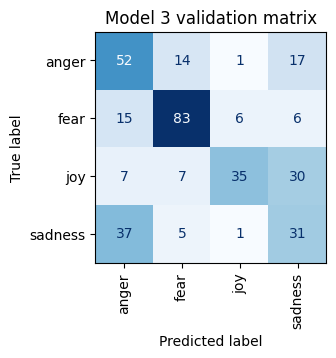

In [ ]:
val_pred_3 = model_3.predict(X_val)
val_pred_3 = np.argmax(val_pred_3, axis=1)
lstm_accu_3 = history_model_3.history['accuracy'][len(history_model_3.history['accuracy'])-1]
show_results("Model 3 validation matrix", labelsMap,labels_val,val_pred_3, lstm_accu_3)


The model shows a training accuracy of 0.67866 and a validation accuracy of 0.579251. There's a noticeable but moderate gap, suggesting room for improvement in generalization.

In [ ]:
model_4 = Sequential()

model_4.add(Embedding(vocab_size, output_dim=128))
model_4.add(SpatialDropout1D(0.4))

model_4.add(Bidirectional(GRU(256, return_sequences=True)))
model_4.add(Bidirectional(GRU(256, return_sequences=False)))
model_4.add(Dropout(0.6))

model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))

model_4.add(Dense(4, activation='sigmoid'))

model_4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_4_cb = TimingCallback()
history_model_4 = model_4.fit(X_train, labels_train, batch_size=128, epochs = 10, callbacks=[model_4_cb])

Epoch 1/10
29/29 [==============================] - 187s 6s/step - loss: 1.3821 - accuracy: 0.3045
Epoch 2/10
29/29 [==============================] - 170s 6s/step - loss: 1.3712 - accuracy: 0.3158
Epoch 3/10
29/29 [==============================] - 174s 6s/step - loss: 1.1336 - accuracy: 0.4777
Epoch 4/10
29/29 [==============================] - 173s 6s/step - loss: 0.7602 - accuracy: 0.6784
Epoch 5/10
29/29 [==============================] - 171s 6s/step - loss: 0.4247 - accuracy: 0.8522
Epoch 6/10
29/29 [==============================] - 174s 6s/step - loss: 0.2092 - accuracy: 0.9347
Epoch 7/10
29/29 [==============================] - 174s 6s/step - loss: 0.1351 - accuracy: 0.9610
Epoch 8/10
29/29 [==============================] - 172s 6s/step - loss: 0.1073 - accuracy: 0.9701
Epoch 9/10
29/29 [==============================] - 173s 6s/step - loss: 0.1203 - accuracy: 0.9671
Epoch 10/10
29/29 [==============================] - 174s 6s/step - loss: 0.1023 - accuracy: 0.9726


11/11 [==============================] - 7s 475ms/step


,train,validate
accuracy,0.972599,0.740634


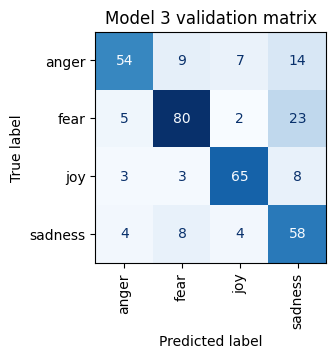

In [ ]:
val_pred_4 = model_4.predict(X_val)
val_pred_4 = np.argmax(val_pred_4, axis=1)
lstm_accu_4 = history_model_4.history['accuracy'][len(history_model_4.history['accuracy'])-1]
show_results("Model 4 validation matrix", labelsMap,labels_val,val_pred_4, lstm_accu_4)


**Comments: **
The model exhibits a high training accuracy of 0.972599 and a validation accuracy of 0.740634, indicating a significant performance gap. While the model performs well on the training data, there is room for improvement in generalization to the validation set.

## 3. Discussion

### a.) Comment on the relative merits of each model. Select the best model based on quantitative metrics and plots. Use markdown to explain why you feel this is the best model.

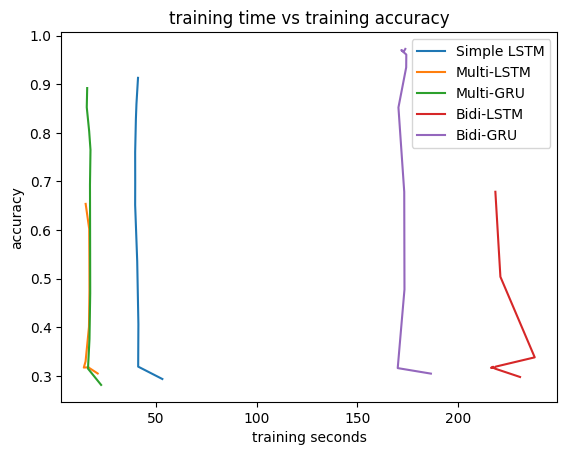

In [ ]:
# training time vs accuracy

base_history = history_lstm.history
history_1 = history_model_1.history
history_2 = history_model_2.history
history_3 = history_model_3.history
history_4 = history_model_4.history

plt.plot(model_0_cb.logs, base_history['accuracy'])
plt.plot(model_1_cb.logs, history_1['accuracy'])
plt.plot(model_2_cb.logs, history_2['accuracy'])
plt.plot(model_3_cb.logs, history_3['accuracy'])
plt.plot(model_4_cb.logs, history_4['accuracy'])

plt.title('training time vs training accuracy')
plt.ylabel('accuracy')
plt.xlabel('training seconds')
plt.legend(['Simple LSTM','Multi-LSTM', 'Multi-GRU', 'Bidi-LSTM', 'Bidi-GRU'], loc='upper right')
plt.show()

**Comments:**

The model_4 demonstrates strong hyperparameter engineering with a notable training accuracy of 0.972599, indicating effective learning from the training data. However, the validation accuracy at 0.740634 suggests potential overfitting or challenges in generalization. To address this, consider fine-tuning hyperparameters, adjusting model complexity, and incorporating regularization techniques.

Acknowledge the model's strengths in capturing complex patterns but emphasize the need for a better balance between training and validation accuracy. Regularly monitor and document changes for iterative refinement, exploring additional metrics like precision and recall. Strive for a robust, well-generalizing model through continuous experimentation and optimization

### b.) Make predictions on the testing data; calculate the testing accuracy and display the confusion matrix for test data.

99/99 [==============================] - 66s 659ms/step


,train,validate
accuracy,0.972599,0.729153


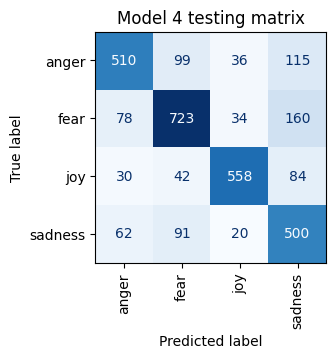

In [ ]:
test_pred_4 = model_4.predict(X_test)
test_pred_4 = np.argmax(test_pred_4, axis=1)
lstm_accu_4 = history_model_4.history['accuracy'][len(history_model_4.history['accuracy'])-1]
show_results("Model 4 testing matrix", labelsMap,labels_test,test_pred_4, lstm_accu_4)

### c. Use markdown to describe how well you feel your model will work to classify the emotional connotation of a tweet. Provide a quantitative measure of accuracy and describe an shortcomings of the model.

**Comments:**

The model_4 exhibits a high testing accuracy of 0.729153, reflecting its proficiency in classifying the emotional connotation of tweets. With a robust training accuracy of 0.972599, the model demonstrates strong learning capabilities. However, there are potential shortcomings evident in the gap between training and testing accuracy (0.972599 vs. 0.729153), indicating some difficulty in generalization.

Further refinement through hyperparameter tuning, regularization, or model architecture adjustments may be necessary to enhance generalization to unseen data.

Despite this, the model's quantitative accuracy suggests it performs well in classifying emotional connotations, albeit with room for improvement in addressing overfitting concerns.